# Model of auxotrophic communities with mutations in update and production rates of amino acids

Note: equation numbers refer to main text of van Vliet et al Plos Comp Bio 2022.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))


## Community class definition
We start with defining a python class that describes community using equation from van Vliet et al Plos Comp Bio 2022.
You do not need to modify anything here

In [107]:
class community:
    """Class for a community of auxotrophs, based on model described in van Vliet et al, PLoS Comp Bio 2020"""

    def __init__(self, c_up=1, c_prod=1, c_cost=1):
        """Initialize the community with a set of parameters
        
            c_up: factor that scales uptake rate of pro in dPro
            c_prod: factor that scales production rate of trp in dPro
            c_cost: factor that scales growth rate of dPro mutant
        
        """
          
        # parameters for the model, see S1 Table in the paper
        self.upPro = 2.04 
        self.upTrp = 24.05 
        self.DiffP = 879 
        self.DiffT = 659 
        self.lPro = 1.59e-5
        self.lTrp = 6.04e-7 
        self.ic = 20 
        self.mu0 = 1.29/3600 
        self.rho = 0.65 
        self.rho2d = 0.22 
        self.cell_l = 5.2 
        self.cell_w = 0.68 
        self.beta = 0.88
        
        #set scaling factors
        self.c_up = c_up
        self.c_prod = c_prod
        self.c_cost = c_cost
        
        #calc community properties
        self.calc_interaction_parameters()
        self.calc_eq_prop() 
    
    def calc_interaction_parameters(self):
        #calculate interaction parameters of the community
        #DP depends on Pro, producer of Pro is DT, non-producer is DP
        self.muP = self.calc_mu_max(up_auxo = self.upPro * self.c_up, 
                                    leak_auxo = self.lPro, 
                                    up_prod = self.upPro, 
                                    leak_prod = self.lPro,
                                    mu_auxo=self.mu0 * self.c_cost
                                    )
        
        self.rangeP = self.calc_int_range(up_auxo = self.upPro * self.c_up, 
                                          leak_auxo = self.lPro, 
                                          up_prod = self.upPro, 
                                          leak_prod = self.lPro,
                                          D = self.DiffP,
                                          mu_auxo=self.mu0 * self.c_cost
                                          )
        
        self.nbP = self.calc_int_nb(self.rangeP)
        
        #DT depends on Trp, producer of Trp is DP, non-producer is DT
        self.muT = self.calc_mu_max(up_auxo = self.upTrp, 
                                    leak_auxo = self.lTrp, 
                                    up_prod = self.upTrp, 
                                    leak_prod = self.lTrp * self.c_prod)
        
        self.rangeT = self.calc_int_range(up_auxo = self.upTrp, 
                                          leak_auxo = self.lTrp, 
                                          up_prod = self.upTrp, 
                                          leak_prod = self.lTrp * self.c_prod,
                                          D = self.DiffT)        
        
        self.nbT = self.calc_int_nb(self.rangeT)
        
        return None
    
    
    def calc_mu_max(self, up_auxo=1, up_prod=1, leak_auxo=1, leak_prod=1, mu_auxo=None):
        """Calculate the maximum growth rate of the cell

        Following equation 10 & 11 in S1 Text
        
        Growth rate is returned in units of h^-1 
        
        """
        
        mu_auxo = self.mu0 if mu_auxo is None else mu_auxo

        theta = ((leak_prod * self.ic)/(2 * mu_auxo)) * ((up_auxo + leak_auxo)/(up_prod + leak_prod))
        mu_max = mu_auxo * theta * (np.sqrt(1 + 2 / theta) - 1)        
        return 3600*mu_max
    
    def calc_int_range(self, up_auxo=1, up_prod=1, leak_auxo=1, leak_prod=1, D=1, mu_auxo=None):
        '''calculate the interaction range of the cell
        
        Following equation 17 in S1 Text
        
        Range is returned in units of um
        
        '''
        
        mu_auxo = self.mu0 if mu_auxo is None else mu_auxo
        
        theta = ((leak_prod * self.ic)/(2 * mu_auxo)) * ((up_auxo + leak_auxo)/(up_prod + leak_prod))
        delta = theta * (2 * np.sqrt(up_prod + leak_prod)) / (np.sqrt(up_auxo + leak_auxo) + np.sqrt(up_prod + leak_prod))
        r0 = self.calc_r0(up_auxo, leak_auxo, D, self.rho)
        range = self.beta * r0 *  np.log(4 + \
                delta * (1 + np.sqrt(1 + 4 / delta)))
        return range
    
    def calc_int_nb(self, range):
        '''convert interaction range to number of neighbors
        
        Following equation 21 in S1 Text
        
        '''
        range = (2 * range * (self.cell_l - self.cell_w) + np.pi * (range + self.cell_w/2)**2 - np.pi * (self.cell_w/2)**2) * self.rho2d
        return np.round(range)
        
    def calc_eq_prop(self):
        '''calculate equilibrium properties of the community
        
        Equilibrium frequency (eq) is calculated following equation 16 in S2 Text
        Equilibrium frequency in well mixed system (eq_wm) is calculated following equation 20 in S2 Text
        Clustering of DT (clusteringT) and DP (clusteringP) is calculated following equation 17 and 18 in S2 Text
        Community growth rate relative to growth rate in well mixed system (rel_growth) is calculated following equation 29 & 30 in S2 Text
        
        '''
        self.eq = (self.muT * (self.nbT - 2)/self.nbT + (self.muT/self.nbT - self.muP/self.nbP)) / (self.muT * (self.nbT - 2)/self.nbT + self.muP * (self.nbP - 2)/self.nbP)
        self.eq_wm = self.muT / (self.muT + self.muP)      
        
        self.clusteringT = (self.nbT - 2) / (self.nbT - 1)
        self.clusteringP = (self.nbP - 2) / (self.nbP - 1)

        pT = self.eq
        pP = 1-self.eq
        pPT = self.clusteringT * pP 
        pTP = self.clusteringP * pT
        growth = pT * pPT * self.muT + pP * pTP * self.muP
        growth_wm = self.eq_wm * (1-self.eq_wm) * self.muT + (1-self.eq_wm) * self.eq_wm * self.muP
                
        self.rel_growth = growth / growth_wm
        
        return None
    
    def calc_growth_profiles(self, x_vec=np.linspace(0,10,100)):
        ''' Calculates growth profiles of the community, assuming the two types occupy different sides of the community.
        
        DT on left, x<0; DP on right, x>0
        '''
        
        #Calculate growth profile of DT
        lTrp_prod = self.lTrp * self.c_prod # production rate of Trp in DP
        ext_Trp = self.ext_profile_auxo(x_vec, 
                                        up_prod=self.upTrp, 
                                        leak_prod=lTrp_prod, 
                                        r0_prod=self.calc_r0(self.upTrp, lTrp_prod, self.DiffT, self.rho), 
                                        r0_auxo=self.calc_r0(self.upTrp, self.lTrp, self.DiffT, self.rho))
        
        int_Trp = self.int_of_ext(ext_Trp, up=self.upTrp, leak=self.lTrp, mu0=self.mu0)
        self.mu_profile_T = self.mu_of_int(int_Trp, mu0=self.mu0) 
        self.x_T = -x_vec
        
        #Calculate growth profile of DP
        upPro_auxo = self.upPro * self.c_up # uptake rate of Pro in DP
        ext_Pro = self.ext_profile_auxo(x_vec, 
                                        up_prod=self.upPro, 
                                        leak_prod=self.lPro, 
                                        r0_prod=self.calc_r0(self.upPro, self.lPro, self.DiffP, self.rho), 
                                        r0_auxo=self.calc_r0(upPro_auxo, self.lPro, self.DiffP, self.rho))
        
        int_Pro = self.int_of_ext(ext_Pro, up=upPro_auxo, leak=self.lPro, mu0=self.mu0 * self.c_cost)
        
        self.mu_profile_P = self.mu_of_int(int_Pro, mu0=self.mu0 * self.c_cost)
        self.x_P = x_vec

        return None
    
    def report_properties(self):
        '''report properties of the community'''
        print(f"Frequency dT = {self.eq:.2f}")
        print(f"Clustering dT = {self.clusteringT:.2f}, Clustering dP = {self.clusteringP:.2f}")
        print(f"Growth defect spatial community = {self.rel_growth:.2f}")        
        print(f"mu_max dP = {self.muP:.2f}, mu_max dT = {self.muT:.2f}")
        print(f"range dP = {self.rangeP:.2f}um, range dT = {self.rangeT:.2f}um")
        
        return None
    
    def ext_profile_prod(self, x_vec, leak_prod=1, up_prod=1, r0_prod=1, r0_auxo=1):
        ''' Calculate external concentration profile in area of producer
        
        Following equation 14 in S1 Text
        
        '''
        ext = self.ic * leak_prod * (r0_auxo - r0_prod * np.exp(x_vec/r0_prod) + r0_prod) / \
                ((leak_prod + up_prod) * (r0_auxo + r0_prod))
        return ext
        
    def ext_profile_auxo(self, x_vec, leak_prod=1, up_prod=1, r0_prod=1, r0_auxo=1):
        ''' Calculate external concentration profile in area of auxotroph
        
        Following equation 14 in S1 Text
        
        '''        
        ext = self.ic * leak_prod * r0_auxo * np.exp(-x_vec/r0_auxo) / \
                ((leak_prod + up_prod) * (r0_auxo + r0_prod))
        return ext        
        
    def calc_r0(self, up, leak, D, rho):
        ''' Calculate length scale of diffusion, r0
        
        Following equation 12 in S1 Text
        
        '''
        
        effective_D = D * (1 - rho)**2 / (rho * (1 + rho / 2))
        return np.sqrt( (effective_D) / (up + leak))
    
    def int_of_ext(self, ext, up=1, leak=1, mu0=1):
        ''' Convert external concentration to internal concentration
        
        Following equation 7 in S1 Text
        
        '''
        intC = ((up + leak) * ext - leak + np.sqrt(((up + leak)*ext + leak)**2 + 4 * (up + leak) * mu0 * ext) ) / (2 * (mu0 + leak))
        return intC
    
    def mu_of_int(self, intC, mu0=1):
        ''' Calculate growth rate from internal concentration
        
        Following Monod equation
        
        Output is in units of h^-1
        
        '''
        return 3600 * (mu0 * intC) / (1 + intC)    

In [95]:
def plot_growth_profile(community):
    ''' Plot growth profiles of the community
    
    Parameters:
    
    community: community object
    
    Returns:
    
    fig: figure object
    
    '''
    
    
    #set colors
    yellow = np.array([246,219,147])/255
    blue = np.array([42,86,152])/255
    
    #calculate growth profiles
    x_vec = np.linspace(0,15,1000)
    community.calc_growth_profiles(x_vec)
    
    #normalize to WT growth rate
    muWT = community.mu0 * 3600
    
    #plot growth profiles
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.plot(community.x_T, community.mu_profile_T/muWT, color=yellow, label='dT')
    ax.plot(community.x_P, community.mu_profile_P/muWT, color=blue, label='dP')
    ax.set_xlabel('Position (um)')
    ax.set_ylabel('Growth rate relative to WT')
    ax.set_ylim(0,1)
    
    #add reference lines
    plt.axvline(x=0, color='k', linestyle='-')
    plt.axvline(x=community.rangeP, color=blue, linestyle=':')
    plt.axvline(x=-community.rangeT, color=yellow, linestyle=':')

    return fig

---

## Check original community

We can now check the properties of the original community to confirm we find the same values as in table S3 of our paper.
There are minor differences as there was a small error in our paper in the conversion of interaction range to number of neighbors.

We also plot the growth rate profiles across the interface. The dotted vertical lines represent the calculated growth range.

Frequency dT = 0.20
Clustering dT = 0.90, Clustering dP = 0.99
Growth defect spatial community = 0.92
mu_max dP = 0.77, mu_max dT = 0.22
range dP = 12.17um, range dT = 2.52um


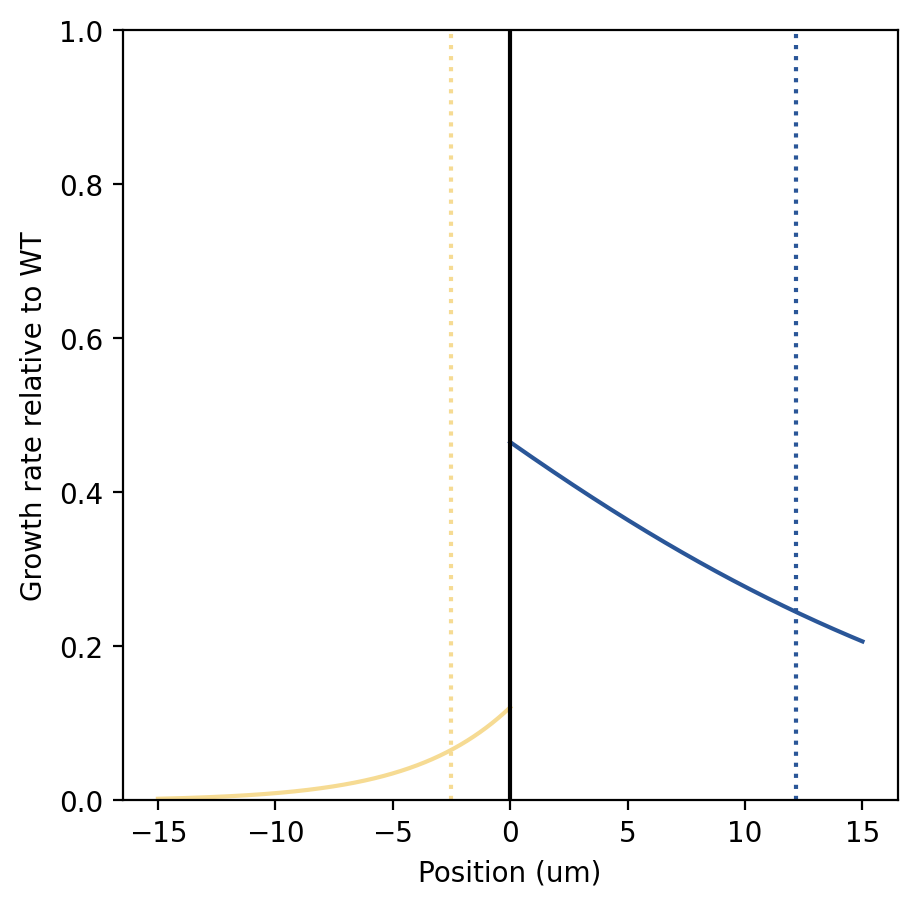

In [108]:
wt_community = community()
wt_community.report_properties()
fig = plot_growth_profile(wt_community)
fig.savefig('growth_profile_wt.pdf')

## Check mutant communities

We can now check properties for the mutant strains. 

For the high uptake mutant we assume that  its uptake rate is increased by a factor c_up (>1), i.e. up_rate = c_up * up_Pro

For the over producing mutant we assume that its leakage rate is increased by factor c_prod (>1), i.e. leak_rate = c_prod * leak_Pro

Note: leakage flux is leakage rate * internal concentration, so increasing internal concentration trough over production rate is mathematical identical to increasing leakage rate in our model.

**Below you can change c_up and c_prod  to see how they affect the community properties.**

### Increased proline uptake mutant

Frequency dT = 0.12
Clustering dT = 0.90, Clustering dP = 0.96
Growth defect spatial community = 0.78
mu_max dP = 1.17, mu_max dT = 0.22
range dP = 4.96um, range dT = 2.52um


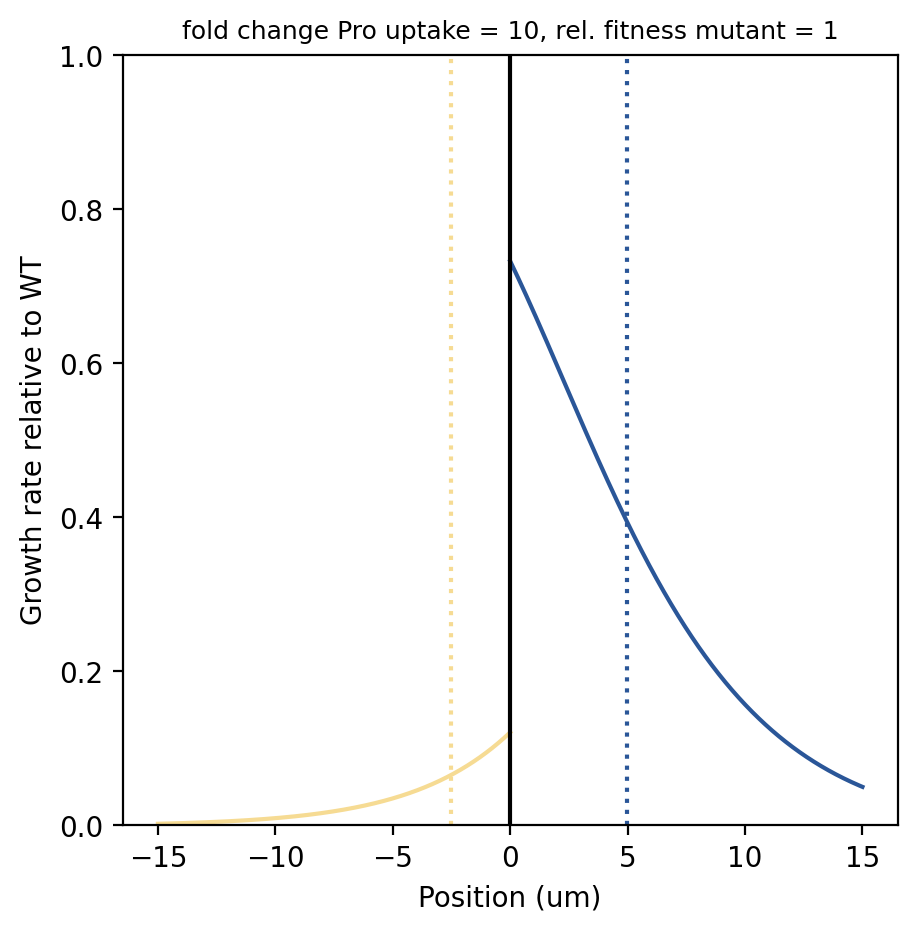

In [138]:
c_up = 10 # SET FOLD CHANGE IN UPTAKE RATE HERE
c_cost_uptake = 1 # SET relative fitness cost of uptake mutation HERE
high_uptake = community(c_up=c_up, c_cost=c_cost_uptake)
high_uptake.report_properties()
fig = plot_growth_profile(high_uptake)
plt.title(f'fold change Pro uptake = {c_up}, rel. fitness mutant = {c_cost_uptake}', fontsize = 9)
fig.savefig('growth_profile_high_uptake.pdf')

### Tryptophan overproduction mutant

Frequency dT = 0.58
Clustering dT = 0.94, Clustering dP = 0.99
Growth defect spatial community = 0.96
mu_max dP = 0.77, mu_max dT = 1.04
range dP = 12.17um, range dT = 3.77um


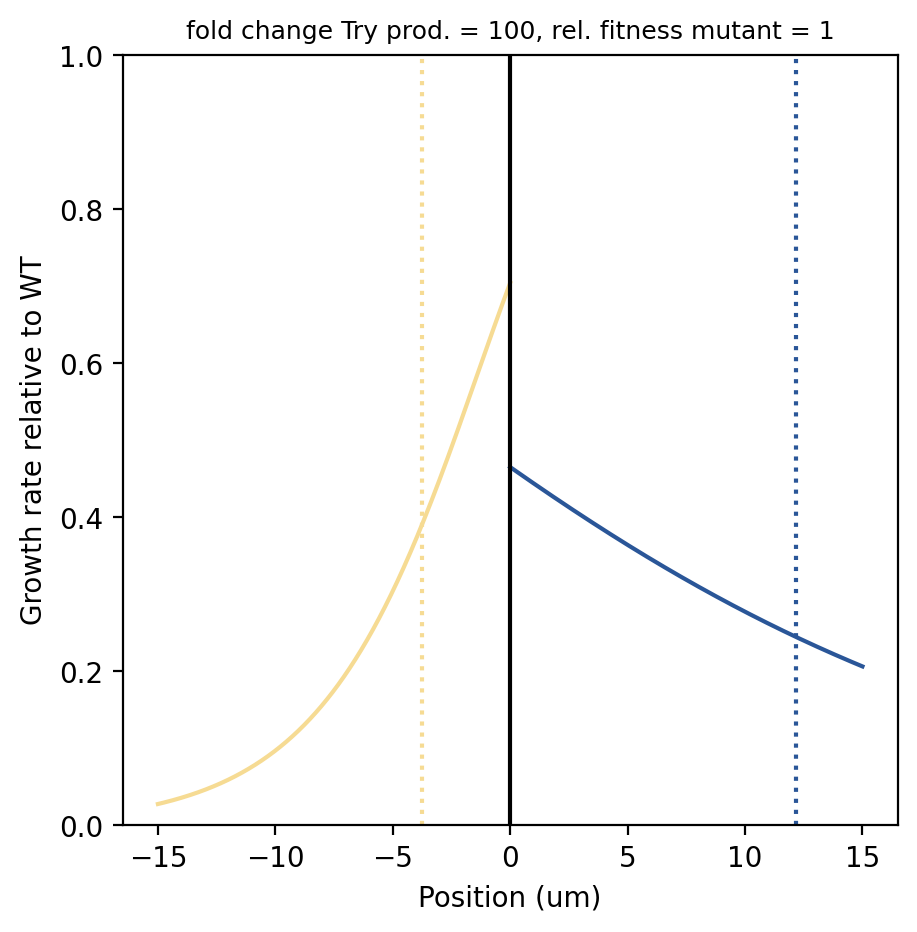

In [142]:
c_prod = 100 # SET FOLD CHANGE IN Trp PRODUCTION RATE HERE
c_cost_overexpression = 1 # SET relative fitness cost of production mutation HERE
high_production = community(c_prod=c_prod, c_cost=c_cost_overexpression)
high_production.report_properties()
fig = plot_growth_profile(high_production)
plt.title(f'fold change Try prod. = {c_prod}, rel. fitness mutant = {c_cost_overexpression}', fontsize = 9)

fig.savefig('growth_profile_high_production.pdf')

### Increased proline uptake & tryptophan overproduction mutant 

Frequency dT = 0.47
Clustering dT = 0.94, Clustering dP = 0.96
Growth defect spatial community = 0.95
mu_max dP = 1.17, mu_max dT = 1.04
range dP = 4.96um, range dT = 3.77um


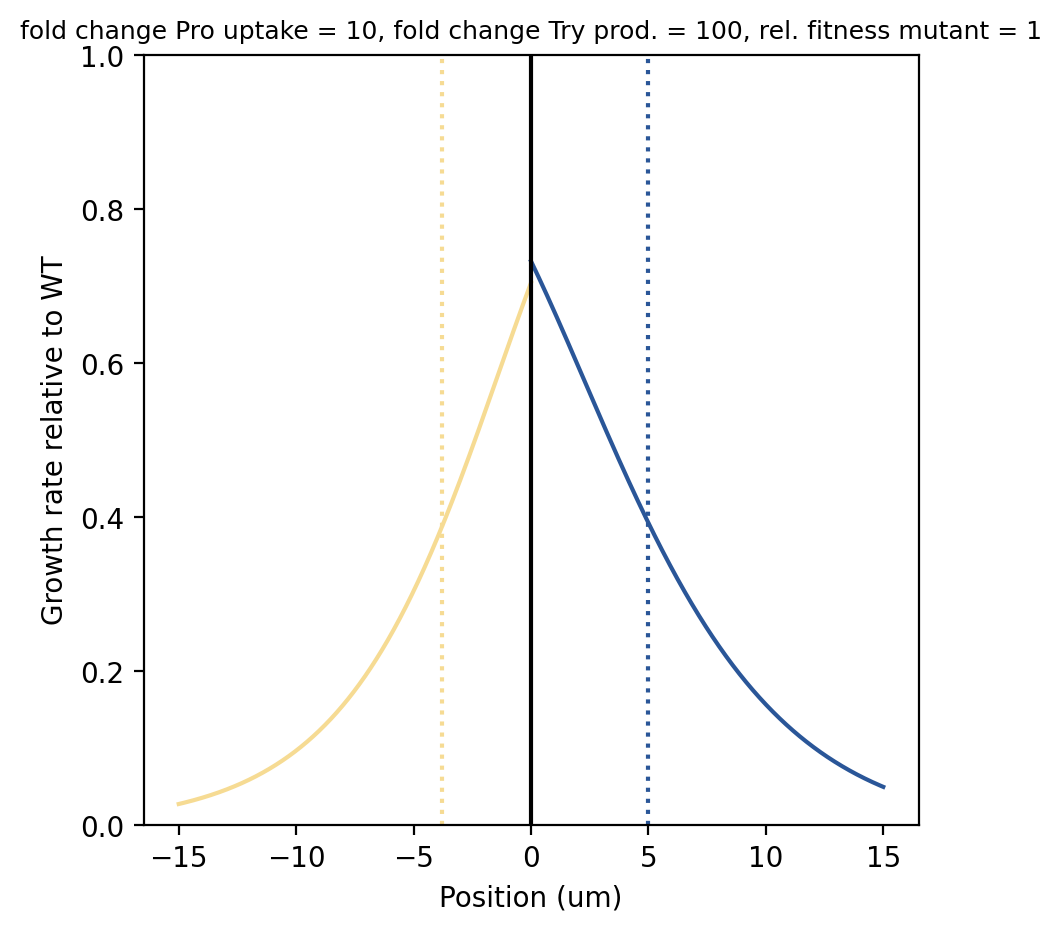

In [144]:
c_cost_uptake_overexpression = 1 # SET relative fitness cost of production + uptake mutations HERE
high_production_high_uptake = community(c_up=c_up, c_prod=c_prod, c_cost=c_cost_uptake_overexpression)
high_production_high_uptake.report_properties()
fig = plot_growth_profile(high_production_high_uptake)
plt.title(f'fold change Pro uptake = {c_up}, fold change Try prod. = {c_prod}, rel. fitness mutant = {c_cost_uptake_overexpression}', fontsize = 9)

fig.savefig('growth_profile_high_production_high_uptake.pdf')

---

## Plot figures
### Heatmap of changing uptake vs changing production

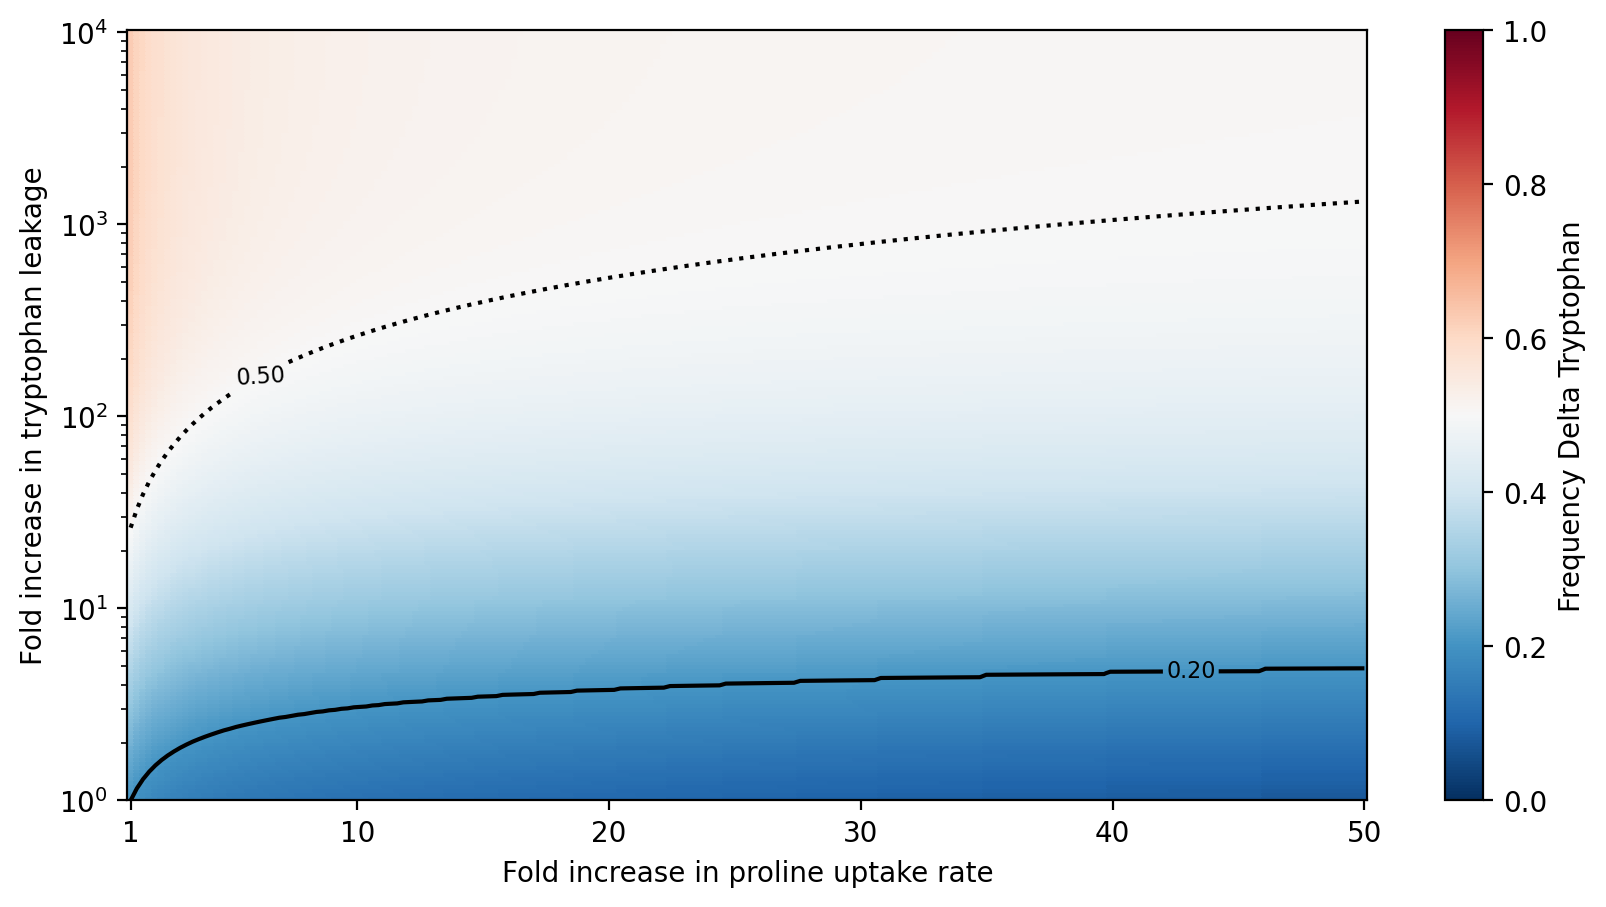

In [89]:
#SET Range of parameters to plot
nstep = 200 
c_up_vec = np.linspace(1,50,nstep) #increase uptake rate from 1 to 12 fold, on lin scale
c_prod_vec = np.logspace(0,4,nstep) #increase production/leakage rate from 1 to 100 fold, on log scale

#calculate equilibrium frequency for all combinations of parameters
c_up, c_prod = np.meshgrid(c_up_vec, c_prod_vec)
community_scan = community(c_up=c_up, c_prod=c_prod)

#plot heatmap of equilibrium frequency
fig, ax = plt.subplots()
f1 = ax.pcolormesh(c_up_vec, c_prod_vec, community_scan.eq, cmap='RdBu_r', vmin=0, vmax=1, edgecolors='face')
#add contour line of original community and 50% frequency
f2 = ax.contour(c_up_vec, c_prod_vec, community_scan.eq, levels=[wt_community.eq,0.5], colors='k',linestyles=['solid','dotted'])
ax.clabel(f2, inline=True, fontsize=8, fmt='%.2f')
#set y-axis to log scale
plt.yscale('log')
#add colorbar
cb = plt.colorbar(f1)
#add labels
cb.set_label('Frequency Delta Tryptophan')
ax.set_xlabel('Fold increase in proline uptake rate')
ax.set_ylabel('Fold increase in tryptophan leakage')
ax.set_xticks([1,10,20,30,40,50]);

#save figure as pdf
plt.savefig('frequency_heatmap.pdf', bbox_inches='tight')

### Line plots increasing tryptophan production rate

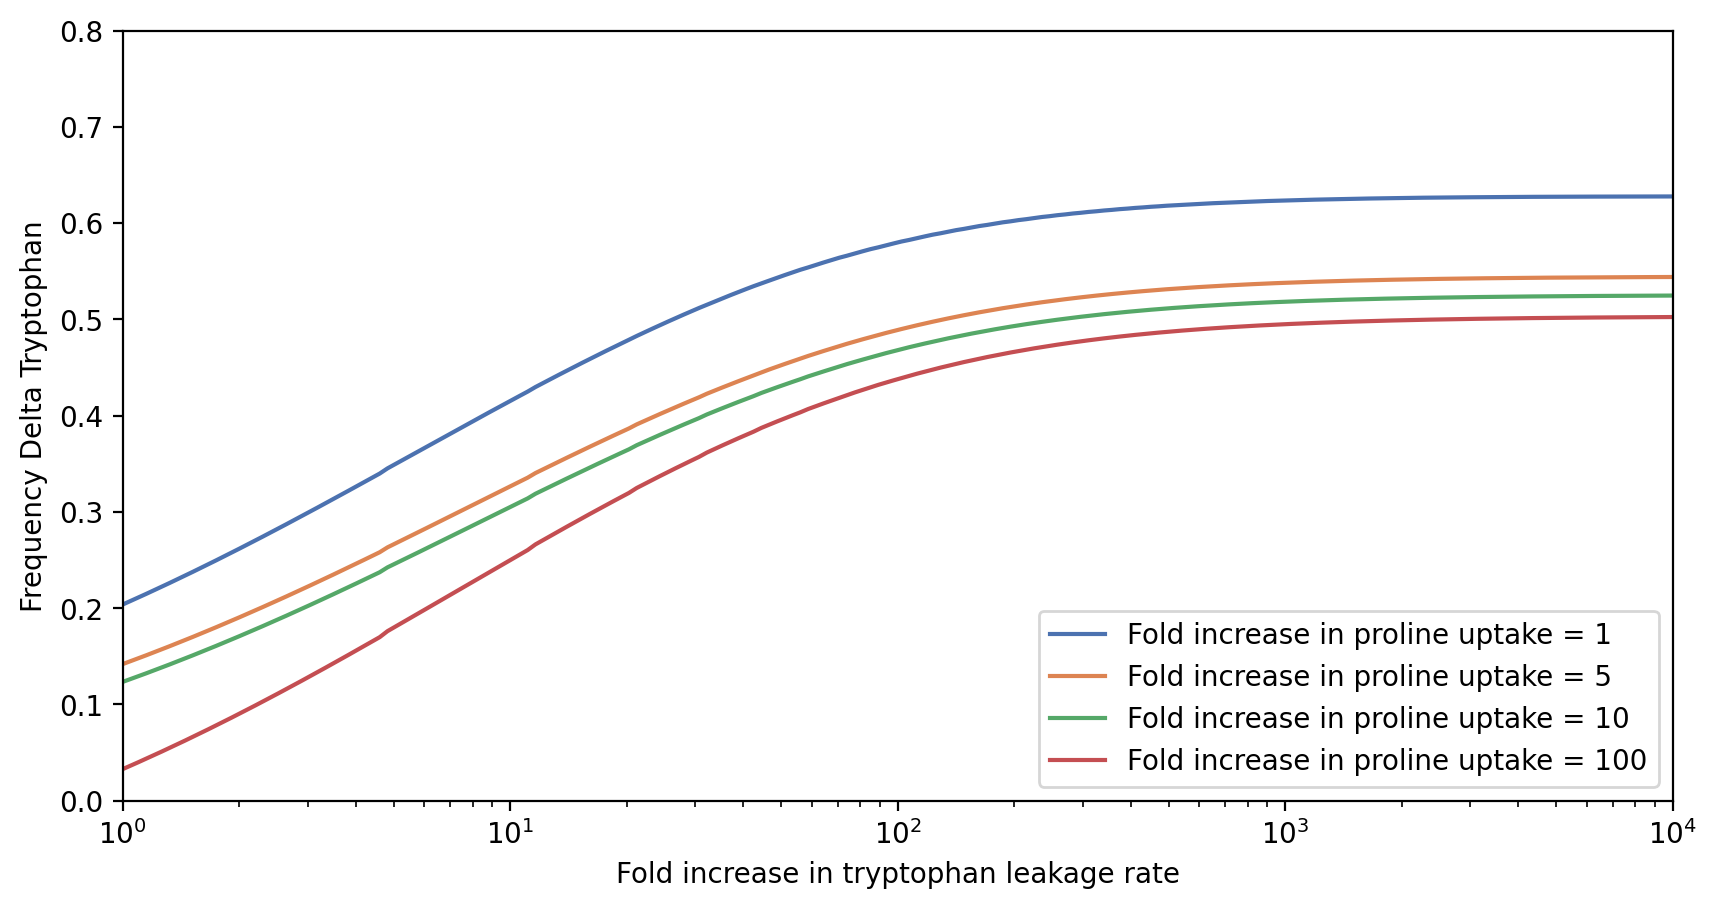

In [117]:
nstep = 200 
c_up_vec = np.array([1,5,10,100]) #compare 3 different rates of proline uptake
c_prod_vec = np.logspace(0,4,nstep) #increase production/leakage rate from 1 to 100 fold, on log scale

#calculate equilibrium frequency for all combinations of parameters
c_up, c_prod = np.meshgrid(c_up_vec, c_prod_vec)
community_upscan = community(c_up=c_up, c_prod=c_prod)

#plot heatmap of equilibrium frequency
fig, ax = plt.subplots()
sns.set_palette('deep')
ax.plot(c_prod_vec, community_upscan.eq);
#add legend based in c_prod_vec
ax.legend([f'Fold increase in proline uptake = {x}' for x in c_up_vec], loc='lower right')
ax.set_xscale('log')
ax.set_xlim([c_prod_vec.min(),c_prod_vec.max()])
ax.set_ylim([0,0.8])
ax.set_xlabel('Fold increase in tryptophan leakage rate')
ax.set_ylabel('Frequency Delta Tryptophan')

plt.savefig('frequency_vs_overproduction.pdf', bbox_inches='tight')

### Line plots increasing proline uptake rate

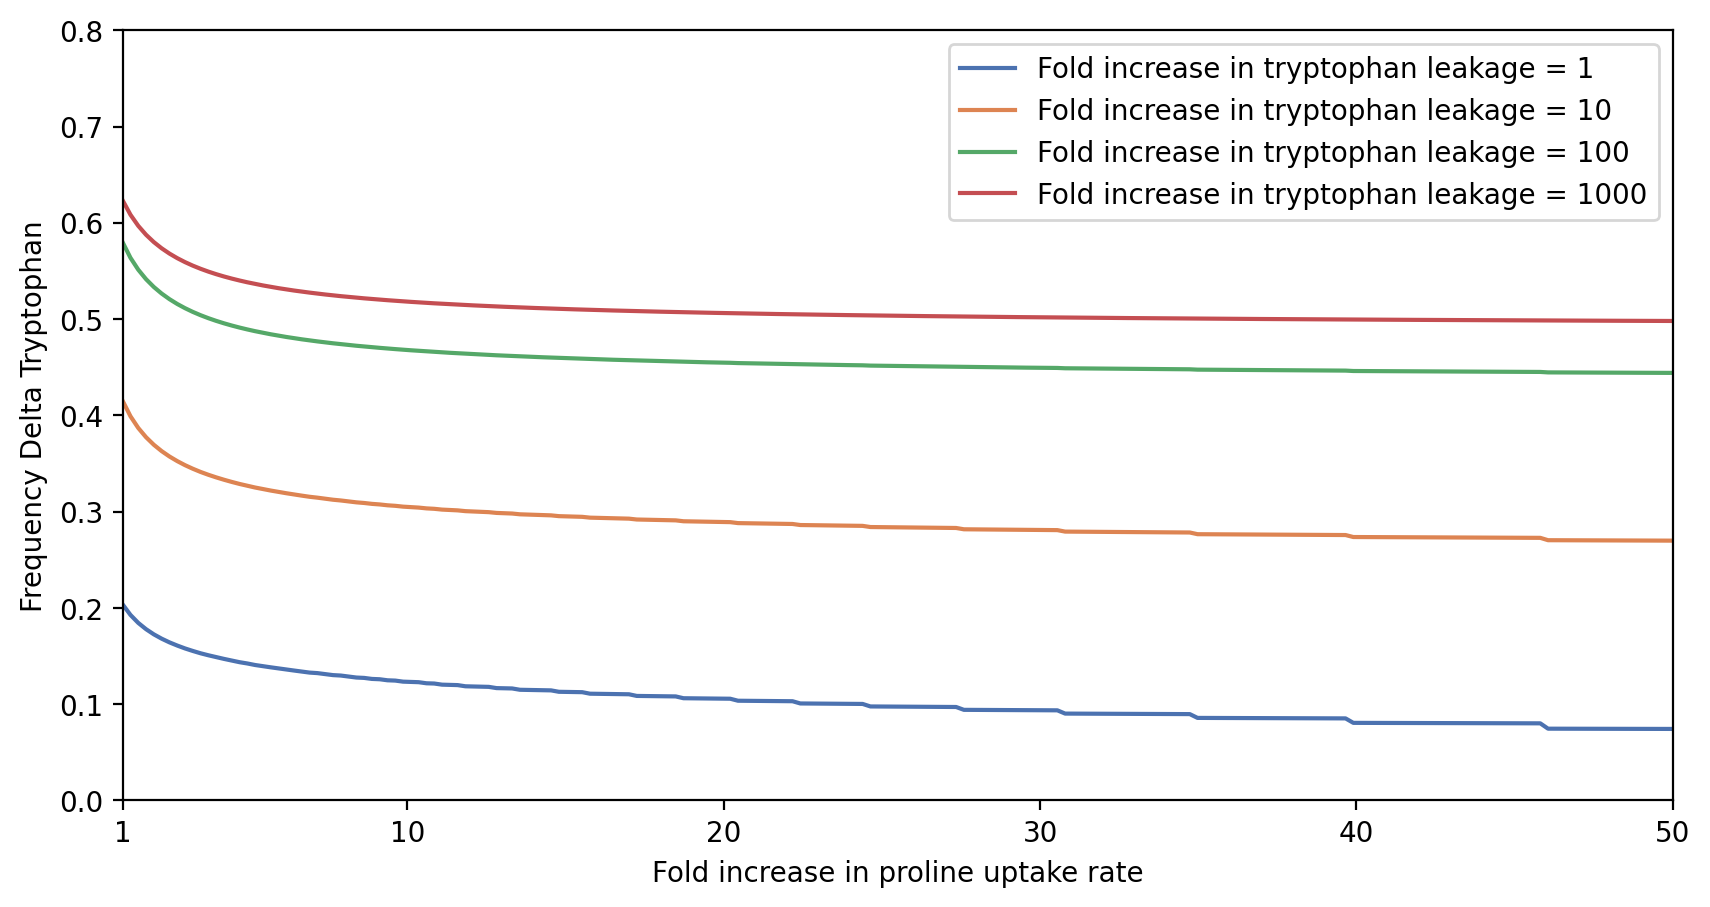

In [118]:
nstep = 200 
c_up_vec = np.linspace(1,50,nstep) #increase uptake rate from 1 to 12 fold, on lin scale
c_prod_vec = [1,10,100,1000] # compare 4 different rates of tryptophan leakage

#calculate equilibrium frequency for all combinations of parameters
c_up, c_prod = np.meshgrid(c_up_vec, c_prod_vec)
community_upscan = community(c_up=c_up, c_prod=c_prod)

#plot heatmap of equilibrium frequency
fig, ax = plt.subplots()
sns.set_palette('deep')
ax.plot(c_up_vec, community_upscan.eq.T);
#add legend based in c_prod_vec
ax.legend([f'Fold increase in tryptophan leakage = {x}' for x in c_prod_vec], loc='upper right')
ax.set_xlim([c_up_vec.min(),c_up_vec.max()])
ax.set_ylim([0,0.8])
ax.set_xlabel('Fold increase in proline uptake rate')
ax.set_ylabel('Frequency Delta Tryptophan')
ax.set_xticks([1,10, 20, 30, 40, 50]);

plt.savefig('frequency_vs_uptake.pdf', bbox_inches='tight')

---

## Plot equilibrium frequency including cost

## Effect of uptake rate, taking over-expression cost into account 

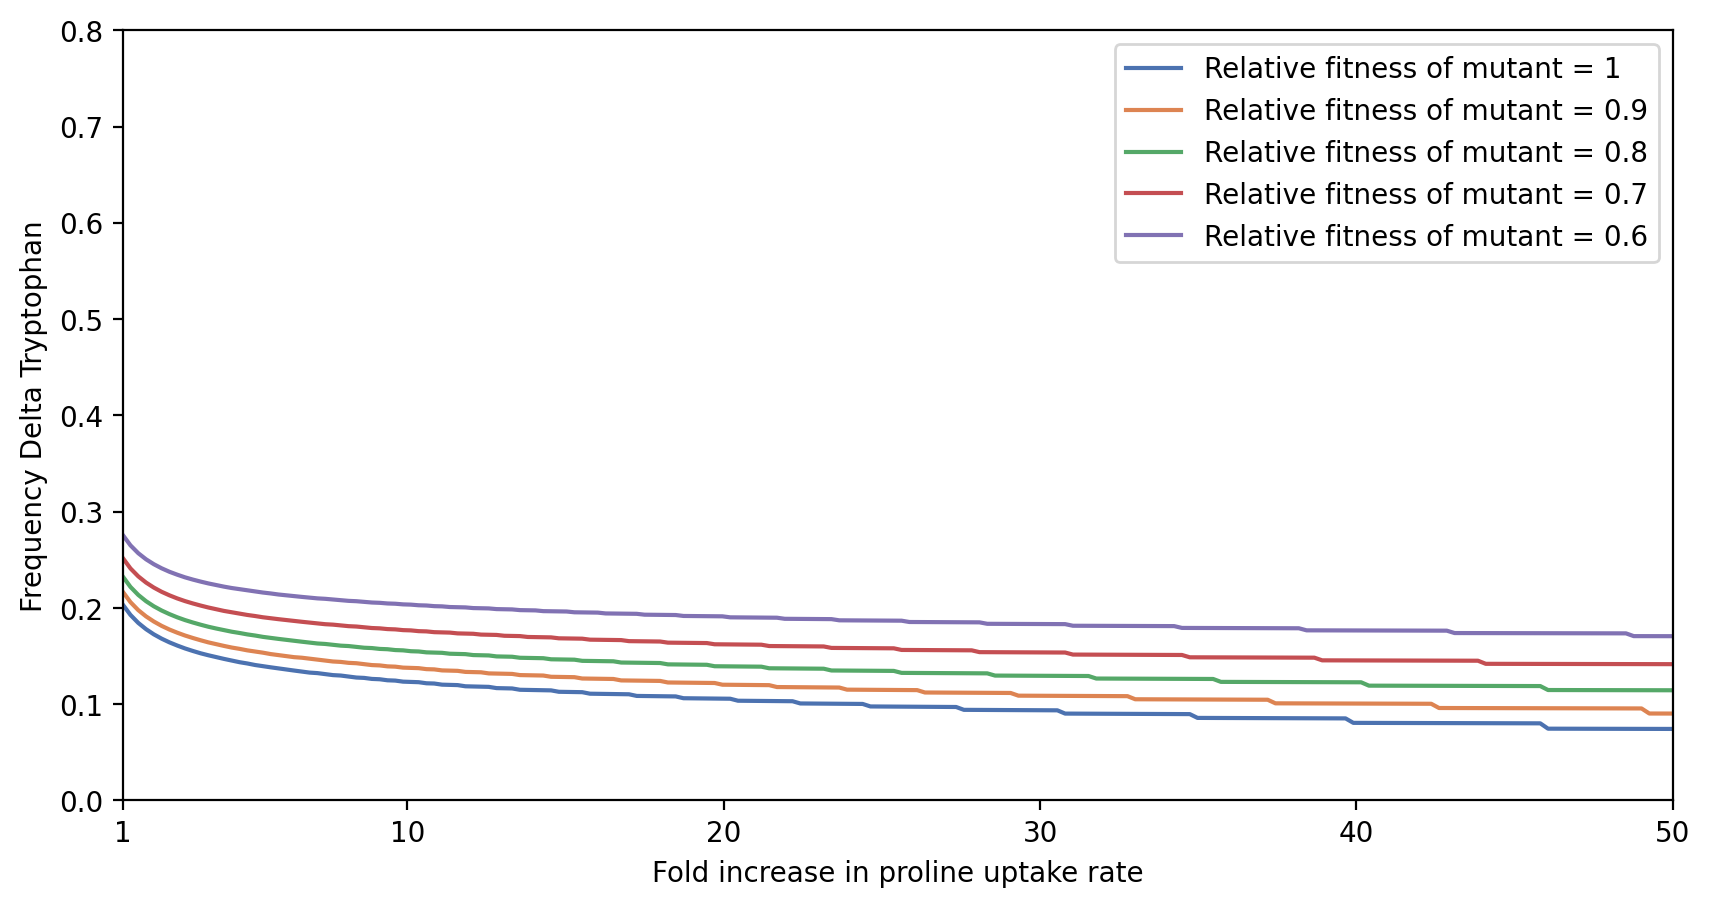

In [131]:
nstep = 200 
c_up_vec = np.linspace(1,50,nstep) #increase uptake rate from 1 to 12 fold, on lin scale
relative_fitness_vec= [1, 0.9, 0.8, 0.7, 0.6] # compare 4 different costs

#calculate equilibrium frequency for all combinations of parameters
c_up, c_cost = np.meshgrid(c_up_vec, relative_fitness_vec)
comm1 = community(c_up=c_up, c_cost=c_cost)

#plot heatmap of equilibrium frequency
fig, ax = plt.subplots()
sns.set_palette('deep')
ax.plot(c_up_vec, comm1.eq.T);
#add legend based in c_prod_vec
ax.legend([f'Relative fitness of mutant = {x}' for x in relative_fitness_vec], loc='upper right')
ax.set_xlim([c_up_vec.min(),c_up_vec.max()])
ax.set_ylim([0,0.8])
ax.set_xlabel('Fold increase in proline uptake rate')
ax.set_ylabel('Frequency Delta Tryptophan')
ax.set_xticks([1,10, 20, 30, 40, 50]);

plt.savefig('frequency_vs_uptake_with_cost.pdf', bbox_inches='tight')

## Effect of production rate, taking over-expression cost into account 

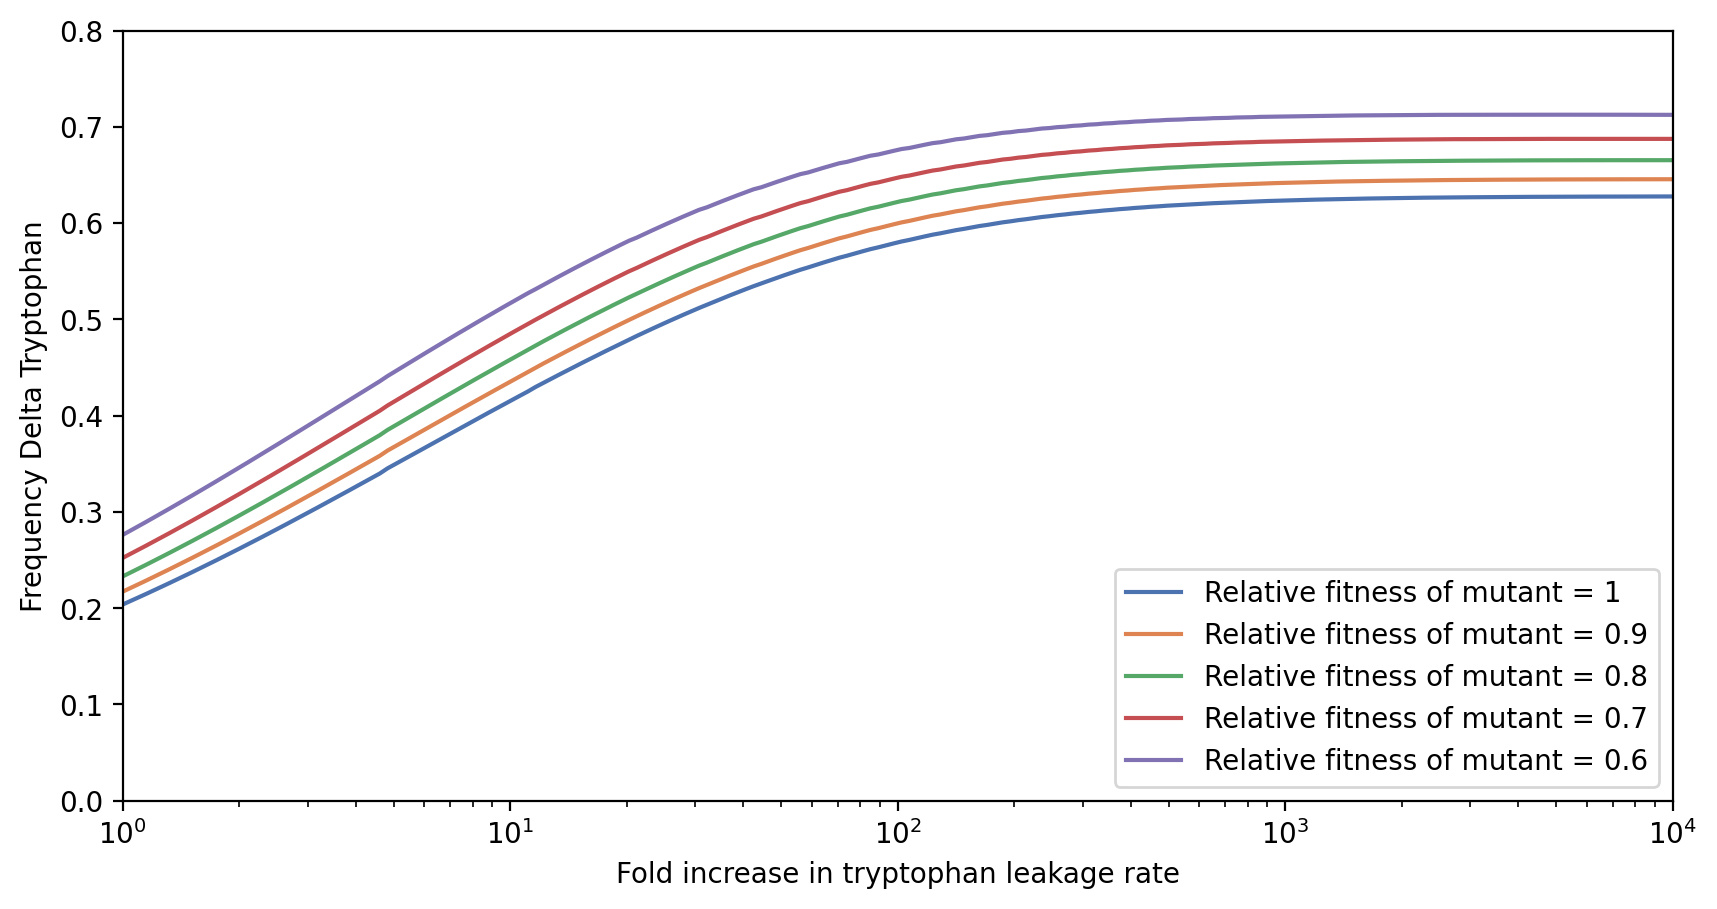

In [130]:
nstep = 200 
c_prod_vec = np.logspace(0,4,nstep) #increase production/leakage rate from 1 to 100 fold, on log scale
relative_fitness_vec= [1, 0.9, 0.8, 0.7, 0.6] # compare 4 different costs

#calculate equilibrium frequency for all combinations of parameters
c_prod, c_cost = np.meshgrid(c_prod_vec, relative_fitness_vec)
comm2 = community(c_prod=c_prod, c_cost=c_cost)

#plot heatmap of equilibrium frequency
fig, ax = plt.subplots()
sns.set_palette('deep')
ax.plot(c_prod_vec, comm2.eq.T);
#add legend based in c_prod_vec
ax.legend([f'Relative fitness of mutant = {x}' for x in relative_fitness_vec], loc='lower right')
ax.set_xscale('log')
ax.set_xlim([c_prod_vec.min(),c_prod_vec.max()])
ax.set_ylim([0,0.8])
ax.set_xlabel('Fold increase in tryptophan leakage rate')
ax.set_ylabel('Frequency Delta Tryptophan')

plt.savefig('frequency_vs_overproduction_with_cost.pdf', bbox_inches='tight')

### Heatmap taking over expression cost into account

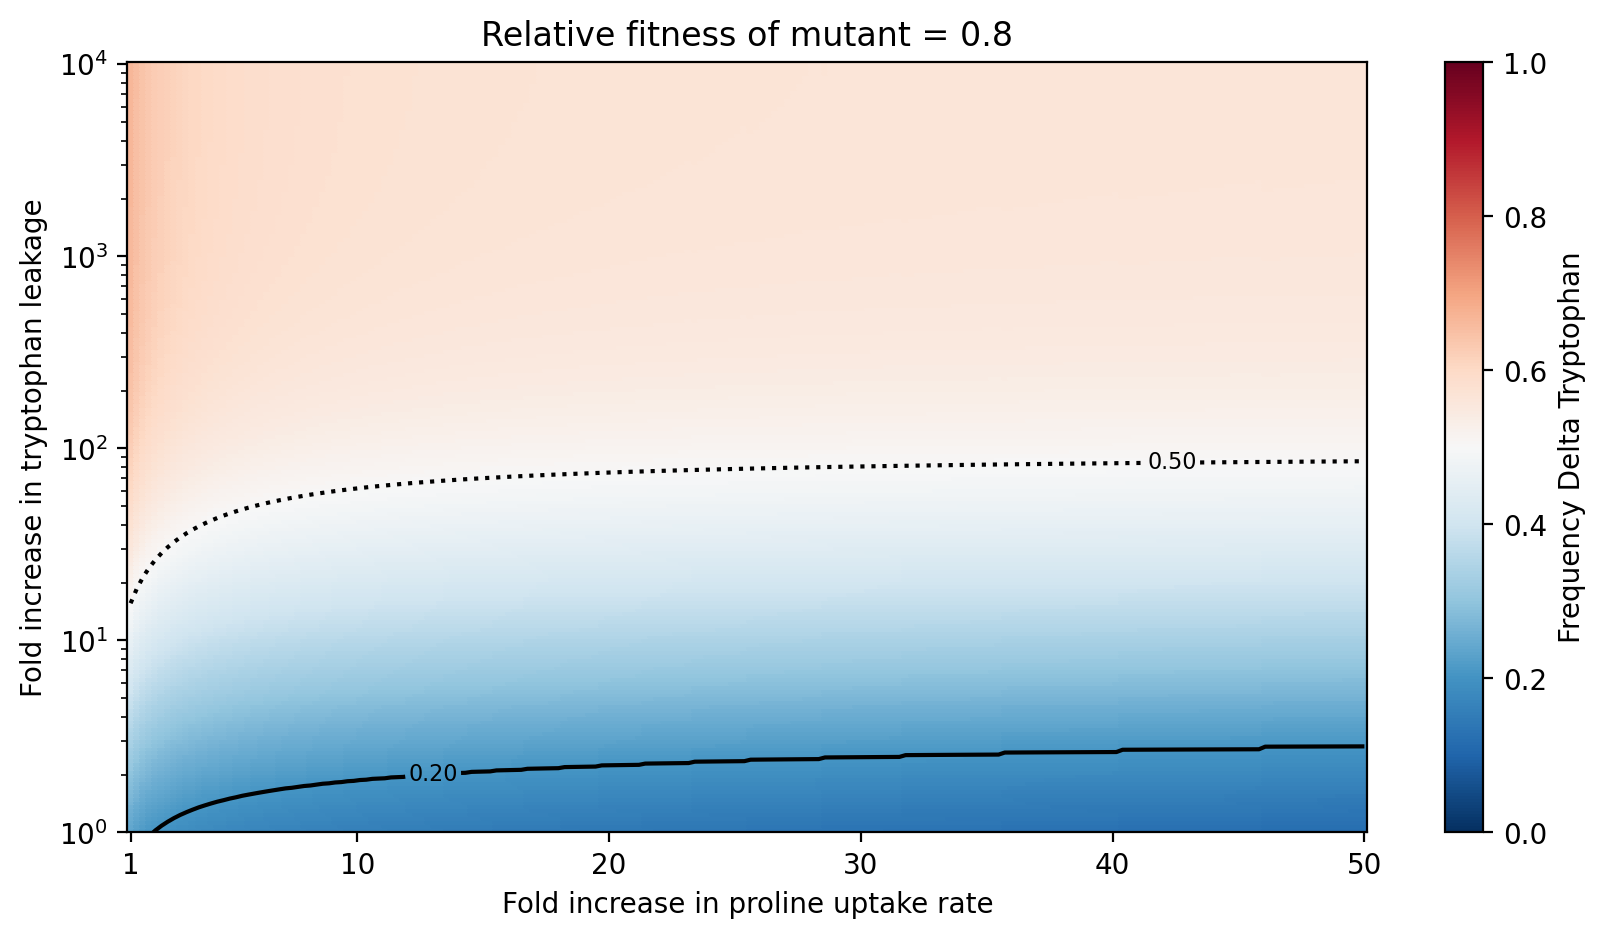

In [132]:
# SET COST OF EXPRESSION MUTATION HERE
relative_fitness = 0.8

#SET Range of parameters to plot
nstep = 200 
c_up_vec = np.linspace(1,50,nstep) #increase uptake rate from 1 to 12 fold, on lin scale
c_prod_vec = np.logspace(0,4,nstep) #increase production/leakage rate from 1 to 100 fold, on log scale

#calculate equilibrium frequency for all combinations of parameters
c_up, c_prod = np.meshgrid(c_up_vec, c_prod_vec)
community_scan = community(c_up=c_up, c_prod=c_prod, c_cost=relative_fitness)

#plot heatmap of equilibrium frequency
fig, ax = plt.subplots()
f1 = ax.pcolormesh(c_up_vec, c_prod_vec, community_scan.eq, cmap='RdBu_r', vmin=0, vmax=1, edgecolors='face')
#add contour line of original community and 50% frequency
f2 = ax.contour(c_up_vec, c_prod_vec, community_scan.eq, levels=[wt_community.eq,0.5], colors='k',linestyles=['solid','dotted'])
ax.clabel(f2, inline=True, fontsize=8, fmt='%.2f')
#set y-axis to log scale
plt.yscale('log')
#add colorbar
cb = plt.colorbar(f1)
#add labels
cb.set_label('Frequency Delta Tryptophan')
ax.set_xlabel('Fold increase in proline uptake rate')
ax.set_ylabel('Fold increase in tryptophan leakage')
ax.set_xticks([1,10,20,30,40,50]);
#add title
plt.title(f'Relative fitness of mutant = {relative_fitness}')

#save figure as pdf
plt.savefig('frequency_heatmap_with_cost.pdf', bbox_inches='tight')